In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from util import datasets, methods, models
from benchmark.noise_invariance import noise_invariance, NoisePerturbedDataset, generate_noise_perturbed_dataset
from os import path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
generate_dataset = True
dataset_name = "MNIST_noise"
original_dataset_name = "MNIST"
data_root = "../data"
batch_size = 4
n_batches = 64
use_logits = False
normalize_attrs = True

In [4]:
if original_dataset_name == "MNIST":
    model = models.MNISTCNN(params_loc=path.join(data_root, "models/mnist_cnn.pth"), output_logits=use_logits)
    model.eval()
    if generate_dataset:
        dataset = datasets.MNIST(batch_size=batch_size, data_location=path.join(data_root, "MNIST"),
                            download=False, shuffle=False)

In [5]:
if original_dataset_name == "CIFAR10":
    model = models.CifarResnet(version="resnet32", 
                               params_loc=path.join(data_root, "models/cifar10_resnet32.pth"),
                               num_classes=10, output_logits=use_logits)
    model.eval()
    if generate_dataset:
        dataset = datasets.Cifar(batch_size=batch_size, data_location=path.join(data_root, "CIFAR10"),
                            download=False, shuffle=False, version="cifar10")

In [6]:
if generate_dataset:
    perturbed_dataset = generate_noise_perturbed_dataset(dataset.get_test_data(),
                                                         path.join(data_root, dataset_name),
                                                         perturbation_levels=list(np.linspace(0, 0.1, 10)),
                                                         n_batches=n_batches,
                                                         model=lambda x: model(x).detach().numpy(), max_tries=2)
else:
    perturbed_dataset = NoisePerturbedDataset(path.join(data_root, dataset_name))

Batch successful: 1/64
Batch successful: 2/64
Batch successful: 3/64
Batch successful: 4/64
Batch successful: 5/64
Batch successful: 6/64
Batch successful: 7/64
Batch successful: 8/64
Batch successful: 9/64
Batch successful: 10/64
Batch successful: 11/64
Batch successful: 12/64
Batch successful: 13/64
Batch successful: 14/64
Batch successful: 15/64
Batch successful: 16/64
Batch successful: 17/64
Batch successful: 18/64
Batch successful: 19/64
Batch successful: 20/64
Batch successful: 21/64
Batch successful: 22/64
Batch successful: 23/64
Batch successful: 24/64
Batch successful: 25/64
Batch successful: 26/64
Batch successful: 27/64
Batch successful: 28/64
Batch successful: 29/64
Batch successful: 30/64
Batch successful: 31/64
Batch successful: 32/64
Batch successful: 33/64
Batch successful: 34/64
Batch successful: 35/64
Batch successful: 36/64
Batch successful: 37/64
Batch successful: 38/64
Batch successful: 39/64
Batch successful: 40/64
Batch successful: 41/64
Batch successful: 42/64
B

In [7]:
attribution_methods = {
    #"GuidedGradCAM": methods.GuidedGradCAM(model, model.get_last_conv_layer(), normalize=normalize_attrs),
    "Gradient": methods.Gradient(model, normalize=normalize_attrs),
    "InputXGradient": methods.InputXGradient(model, normalize=normalize_attrs),
    "IntegratedGradients": methods.IntegratedGradients(model, normalize=normalize_attrs),
    "GuidedBackprop": methods.GuidedBackprop(model, normalize=normalize_attrs),
    "Deconvolution": methods.Deconvolution(model, normalize=normalize_attrs)
}

In [8]:
result = noise_invariance(perturbed_dataset, attribution_methods)

Method: Gradient...


/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.6/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


Method: InputXGradient...
Method: IntegratedGradients...
Method: GuidedBackprop...


/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


Method: Deconvolution...


In [12]:
result_df = pd.DataFrame.from_dict(
    {m_name: pd.DataFrame(data=result[m_name]["diffs"]).stack() for m_name in attribution_methods}
).stack().reset_index()
result_df.columns = ["sample", "noise", "method", "difference"]
result_df["noise"] = np.array(perturbed_dataset.perturbation_levels)[result_df["noise"]]

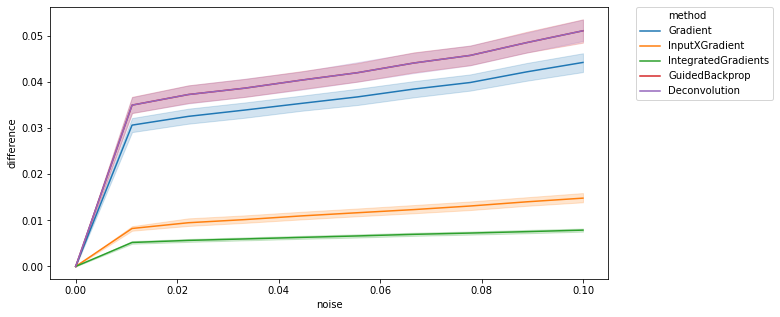

In [13]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="noise", y="difference", hue="method", data=result_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)